In [1]:
import pandas as pd
import ast
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from spacy.tokens import DocBin
from spacy.util import filter_spans
from tqdm import tqdm


sns.set(style='darkgrid', font_scale=1.2)

In [2]:
df_path = "/content/sample_data/mountain_dataset_with_markup.csv"

In [3]:
df = pd.read_csv(df_path, encoding='utf-8')
df.head()

,text,marker
0,A visit to a science museum for hands-on learn...,[]
1,Voice surface coach set democratic time year. ...,[]
2,Parent according maybe activity activity finis...,[]
3,A visit to a sculpture garden with intriguing ...,[]
4,The Julian Alps in Slovenia offer pristine lak...,"[(11, 15)]"


In [4]:
print(type(df['marker'][0]))

<class 'str'>


In [5]:
def change_marker_type_to_list(marker):
    """
    Here I change type of marker column object from str to list
    """
    pattern = r'\((\d+),\s*(\d+)\)'
    matches = re.findall(pattern, marker)
    int_pairs = [(int(start), int(end)) for start, end in matches]
    return int_pairs

df['marker'] = df['marker'].apply(change_marker_type_to_list)

In [6]:
print(type(df['marker'][0]))

<class 'list'>


In [7]:
def extract_mountain_names(row):
    """
    this function aim to extract mountain names from row of
    our dataframe and create a label with 1
    whether a row contain a mountain and 0 otherwise
    """
    text = row['text']
    markers = row['marker']

    mountain_names = []
    for start, end in markers:
        if 0 <= start < end <= len(text):
            mountain = text[start:end]
            mountain_names.append(mountain)
        else:
            print(f"Invalid indices ({start}, {end}) in row: {row.name}")

    return mountain_names
# also we need to remove hashtags as hashtags are located in the end of sentence and wouldnt disturn our extracting mountain names in the future so as our model wouldnt be biased
df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
df['mountain_names'] = df.apply(extract_mountain_names, axis=1)
df['label'] = df['mountain_names'].apply(lambda names: 1 if len(names) > 0 else 0)
df


,text,marker,mountain_names,label
0,A visit to a science museum for hands-on learn...,[],[],0
1,Voice surface coach set democratic time year. ...,[],[],0
2,Parent according maybe activity activity finis...,[],[],0
3,A visit to a sculpture garden with intriguing ...,[],[],0
4,The Julian Alps in Slovenia offer pristine lak...,"[(11, 15)]",[Alps],1
...,...,...,...,...
1579,They never audience meet. Appear region allow ...,[],[],0
1580,Witnessing the mesmerizing Northern Lights dan...,"[(75, 97)]",[Scandinavian Mountains],1
1581,Consumer join stage. Best likely center they p...,[],[],0
1582,Hospital real school cover hotel over. Any tra...,[],[],0


<ipython-input-8-63f8a5d39d87>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="coolwarm")


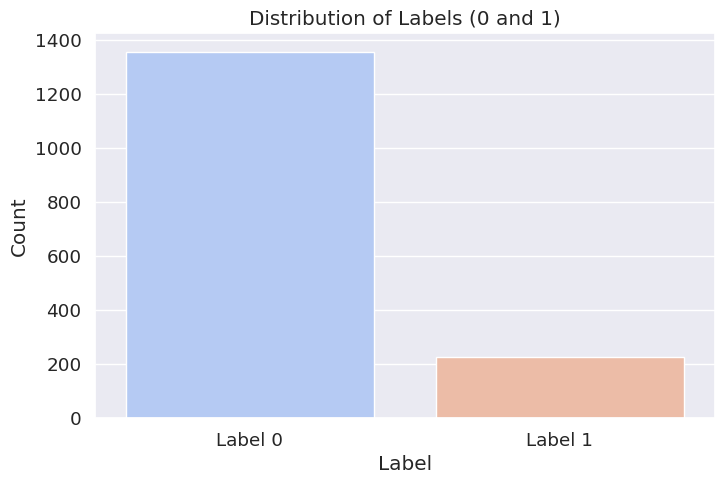

In [8]:
label_counts = df['label'].value_counts()
label_counts = label_counts[label_counts.index.isin([0, 1])]

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="coolwarm")
plt.title('Distribution of Labels (0 and 1)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Label 0', 'Label 1'])
plt.show()

As we can see here we dont have equaly distributed values with label 0 and 1

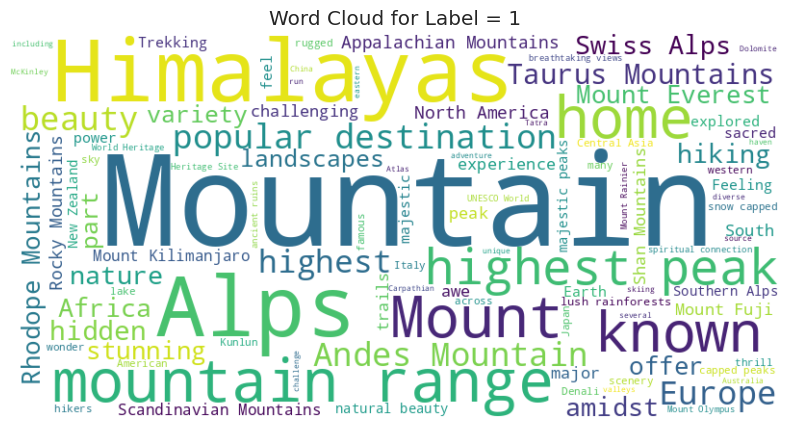

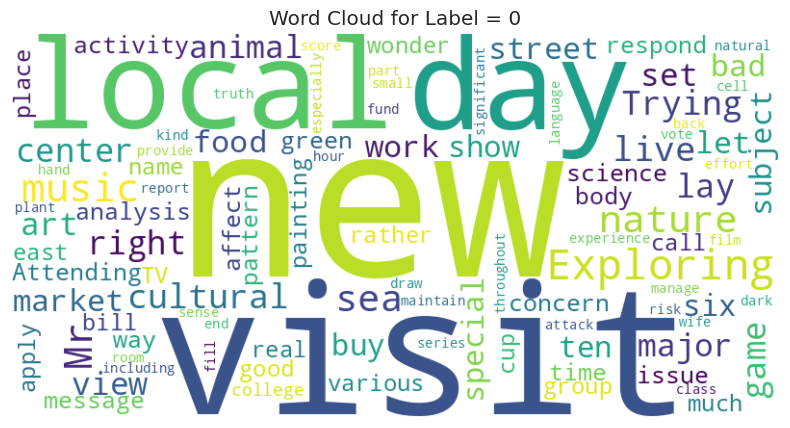

In [9]:
text_label_1 = " ".join(df[df['label'] == 1]['text'])
text_label_0 = " ".join(df[df['label'] == 0]['text'])

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(text_label_1, "Word Cloud for Label = 1")
generate_wordcloud(text_label_0, "Word Cloud for Label = 0")

As we can see in label 0 we do have words thet arent related to mountains usually

In [10]:
df = df.drop(['mountain_names'], axis=1)

In [11]:
df.head(4)

,text,marker,label
0,A visit to a science museum for hands-on learn...,[],0
1,Voice surface coach set democratic time year. ...,[],0
2,Parent according maybe activity activity finis...,[],0
3,A visit to a sculpture garden with intriguing ...,[],0


Here we calculate total accurance of each label to deal with it in the test_train_split

In [12]:
count_label_1 = (df['label'] == 1).sum()
count_label_1

226

In [13]:
count_label_0 = (df['label'] == 0).sum()
count_label_0


1358

Now we will perform train_test_split with condition that 80 % of our label 1 data would be part of train for sure and the same logic with test but only 20 %

In [14]:
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

train_label_1, test_label_1 = train_test_split(df_label_1,
                                                test_size=45,
                                                random_state=42)
# check whether we devided correctly
assert len(train_label_1) == 181, "80%"
assert len(test_label_1) == 45, "20%"

train_label_0, test_label_0 = train_test_split(df_label_0,
                                                test_size=272,
                                                random_state=42)
# check whether we devided correctly
assert len(train_label_0) == 1086, "80%"
assert len(test_label_0) == 272, "20%"

train = pd.concat([train_label_1, train_label_0])
test = pd.concat([test_label_1, test_label_0])

train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)


train_label_1 = train[train['label'] == 1]
train_label_0 = train[train['label'] == 0]


train_label_1_new, dev_label_1 = train_test_split(
    train_label_1,
    test_size=0.25,
    random_state=42
)
# check whether we devided correctly
assert len(train_label_1_new) == 135, "75%"
assert len(dev_label_1) == 46, "25%"

train_label_0_new, dev_label_0 = train_test_split(
    train_label_0,
    test_size=0.25,
    random_state=42
)


assert len(train_label_0_new) == 814, "75%"
assert len(dev_label_0) == 272, "25%"


train_final = pd.concat([train_label_1_new, train_label_0_new])
dev = pd.concat([dev_label_1, dev_label_0])


train_final = train_final.sample(frac=1, random_state=42).reset_index(drop=True)
dev = dev.sample(frac=1, random_state=42).reset_index(drop=True)

print("Training set size:", train.shape)
print("Validation set size:", dev.shape)
print("Test set size:", test.shape)


train.to_csv('train.txt', columns=['label', 'text', 'marker'], index=False, header=False, sep='\t')
dev.to_csv('dev.txt', columns=['label', 'text', 'marker'], index=False, header=False, sep='\t')
test.to_csv('test.txt', columns=['label', 'text', 'marker'], index=False, header=False, sep='\t')


Training set size: (1267, 3)
Validation set size: (318, 3)
Test set size: (317, 3)


In [15]:
train_df = pd.read_csv('train.txt', sep='\t', names=['label', 'text', 'marker'], header=None)
dev_df = pd.read_csv('dev.txt', sep='\t', names=['label', 'text', 'marker'], header=None)
test_df = pd.read_csv('test.txt', sep='\t', names=['label', 'text', 'marker'], header=None)

train_df = train_df.drop(columns = ['label', ], axis = 1)
dev_df = dev_df.drop(columns = ['label'], axis = 1)
test_df = test_df.drop(columns = ['label'], axis = 1)
print(train_df.head(5))

                                                text marker
0  Officer think compare. Option property evidenc...     []
1  Safe hot Mrs development care. Loss look socia...     []
2  Save activity analysis edge fact occur. Author...     []
3  A visit to a historical mansion with well-pres...     []
4  South friend group pass. President employee le...     []


here we perform counting of true names of mountains and will create a list of their names to test our model

In [16]:
train_df['marker'] = train_df['marker'].apply(change_marker_type_to_list)
test_df['marker'] = test_df['marker'].apply(change_marker_type_to_list)
dev_df['marker'] = dev_df['marker'].apply(change_marker_type_to_list)

In [17]:
mountain_names = []
list_ent = []
for idx, row in train_df.iterrows():
    text = row['text']
    marker = row['marker']

    if marker:
        list_ent.append(text)
        for j in range (0, len(marker)):
            start, end = marker[j]
            name = text[start:end]
            mountain_names.append(name)

print(len(mountain_names))

187


Here we perform data preparation, in other words we create dictionary with entities and our text еще further work with it

In [18]:
nlp = spacy.blank("en")
# here we also use DocBin for efficient use
doc_bin = DocBin()
training_data = []
for idx, row in train_df.iterrows():
    text = row['text']
    entities = row['marker']
    temp_dict = {
        'text': text,
        'entities': [(start, end, 'MOUNTAIN') for start, end in entities]
    }
    training_data.append(temp_dict)
print(training_data[1])


{'text': 'Safe hot Mrs development care. Loss look social feel.\nSister wife cost computer back sure. Finish such fly sign lot let on.', 'entities': []}


Here we transform our data to spacy format for further working with it

In [19]:
for training_example in tqdm(training_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("data/train.spacy")

100%|██████████| 1267/1267 [00:00<00:00, 3802.92it/s]


In [20]:
for training_example in tqdm(training_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("data/dev.spacy")

100%|██████████| 1267/1267 [00:00<00:00, 6426.87it/s]


In [21]:
!python -m spacy init fill-config /content/config/Base_case.cfg /content/config/config.cfg


✔ Auto-filled config with all values
✔ Saved config
/content/config/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [24]:
!python -m spacy train  /content/config/config.cfg --output ./ --paths.train ./data/train.spacy --paths.dev ./data/dev.spacy

ℹ Saving to output directory: .
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    

Here we test our model with one sentence

In [25]:
nlp_ner = spacy.load("model-last")
doc = nlp_ner("I recently hiked the Julian Alps in Slovenia.")
spacy.displacy.render(doc, style='ent')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [26]:
!python -m spacy init fill-config  /content/config/base_config.cfg  /content/config/config.cfg

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
✔ Auto-filled config with all values
✔ Saved config
/content/config/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [27]:
!python -m spacy train  /content/config/config.cfg --output ./ --paths.train ./data/train.spacy --paths.dev ./data/dev.spacy --gpu-id 0

ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 137kB/s]
config.json: 100% 481/481 [

Here we test our model with one sentence

In [30]:
nlp = spacy.blank("en")
doc_bin = DocBin()
testing_data = []
for idx, row in test_df.iterrows():
    text = row['text']
    entities = row['marker']
    temp_dict = {
        'text': text,
        'entities': [(start, end, 'MOUNTAIN') for start, end in entities]
    }
    testing_data.append(temp_dict)
print(testing_data[2])

{'text': 'The Patagonian Andes in Argentina and Chile offer stunning landscapes for adventurers.', 'entities': [(15, 20, 'MOUNTAIN'), (4, 20, 'MOUNTAIN')]}


In [35]:
# nlp_ner = spacy.load("model-last")
true_entities = set()
pred_entities = set()

for idx, row in enumerate(testing_data):
    text = row['text']
    entities = row['entities']

    for ent in entities:
        start, end, label = ent
        entity_text = text[start:end]
        true_entities.add((entity_text, start, end, label))

    doc = nlp_ner(text)
    for ent in doc.ents:
        if ent.label_ == "MOUNTAIN":
            pred_entities.add((ent.text, ent.start_char, ent.end_char, ent.label_))

TP = len(true_entities & pred_entities)
FP = len(pred_entities - true_entities)
FN = len(true_entities - pred_entities)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0


print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


True Positives (TP): 40
False Positives (FP): 1
False Negatives (FN): 2
Precision: 0.976
Recall: 0.952
F1 Score: 0.964


In [36]:
# nlp_ner = spacy.load("model-last")
true_entities = set()
pred_entities = set()

for idx, row in enumerate(training_data):
    text = row['text']
    entities = row['entities']

    for ent in entities:
        start, end, label = ent
        entity_text = text[start:end]
        true_entities.add((entity_text, start, end, label))

    doc = nlp_ner(text)
    for ent in doc.ents:
        if ent.label_ == "MOUNTAIN":
            pred_entities.add((ent.text, ent.start_char, ent.end_char, ent.label_))

TP = len(true_entities & pred_entities)
FP = len(pred_entities - true_entities)
FN = len(true_entities - pred_entities)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0


print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


True Positives (TP): 111
False Positives (FP): 0
False Negatives (FN): 2
Precision: 1.000
Recall: 0.982
F1 Score: 0.991
